## HW6：分子动力学模拟（ddl：12.7）
你的名字：

你的学号：


注意：
1. 请使用 Python 语言完成所有编程作业。
2. 允许并鼓励同学间合作，但严禁抄袭别人的代码，且严禁直接复制粘贴由人工智能生成的代码。
3. 请直接在题干后附加代码块和必要的公式，讨论等。
4. 作图请包含 X,Y 轴的标签，以及必要的图例。过多信息的缺失可能会导致丢分。

作业只需要在这个 jupyter notebook 里添加代码，并直接提交修改后的 jupyter notebook，文件请重命名为`姓名-学号-作业x`。

另外请在作业最后**简要说明本次作业完成情况**，以及大致心路历程；另外标注**致谢**，借助了**哪位同学或 ChatGPT 等工具**的帮助，如果自己独立完成的，只需标注"独立完成"。如果上述备注有缺失，会导致作业扣分！

<font color='red'>**1.本次作业中的分子动力学模拟请仅使用ASE库来完成**</font>

<font color='red'>**2.本次作业严格要求保留代码输出结果，缺失会导致失分，请务必重视**</font>

相对地，本次作业依然只需提交这个jupyter notebook即可，不需要附加你在过程中导出的若干其他文件。

### **Pt(111)-水界面的MD模拟**

在课堂上，我们展示了使用`ase`库的内置工具完成对铜晶格融化过程的MD模拟。而在本次作业中，我们来用类似的方法考察一个于电化学、材料科学等领域中备受关注的体系：Pt(111)表面与水分子的相互作用。

这个体系中涉及到的Pt,H,O元素都是`ase`自带的EMT势场所支持的，虽然官方文档中提到其计算结果可靠性不高，但不妨碍我们作为练习来进行尝试。

如果你对于`ase`库与`MDAnalysis`库的使用仍不是很熟悉，强烈建议你参考课上演示用的文档来完成本次作业。

**(a)** 第一步是构建体系，下面直接给出这一部分的代码，请你运行并确认体系的初始几何构型。

In [ ]:
from ase.build import fcc111, molecule
from ase.constraints import FixAtoms, FixInternals
from ase.visualize import view
import numpy as np
# 体系参数
size = (4, 4, 4)      
vacuum = 20.0     

# 构建 Pt(111) 表面与水分子
pt_slab = fcc111('Pt', size=size, vacuum=vacuum)
h2o1 = molecule('H2O')
h2o2 = molecule('H2O')

# 将水分子置于指定高度
z_max_pt = pt_slab.positions[:, 2].max()
placement_height = z_max_pt + 3.0

# 确定 Pt 晶胞的中心 X, Y 坐标
center_x = pt_slab.cell[0][0] / 2.0
center_y = pt_slab.cell[1][1] / 2.0

# 移动水分子
h2o1.positions += [center_x, center_y, placement_height]
h2o2.positions += [center_x+2, center_y, placement_height]

# 合并最终体系
atoms = pt_slab + h2o1 + h2o2

# 体系约束设置
# 1) 固定Pt层底部
npt1 = len(pt_slab)                      # Pt 原子数
npt2 = npt1 + len(h2o1)               
fixed_atom_count = 2 * (size[0] * size[1])  # 固定底下两层

# Pt 的索引在合并后仍是 0..(npt-1)
pt_constraint = FixAtoms(indices=range(fixed_atom_count))

# 2) 为合并后的 atoms 添加刚性水分子约束（注意索引要加上 npt 偏移）
ci = FixInternals(
    bonds=[[None, [npt1, npt1+1]], [None, [npt1, npt1+2]], [None, [npt2, npt2+1]], [None, [npt2, npt2+2]]],
    angles_deg=[[None, [npt1+1, npt1, npt1+2]], [None, [npt2+1, npt2, npt2+2]]]
)
atoms.set_constraint([pt_constraint, ci])  # 施加约束

# 检查约束
print(atoms.constraints)         
print('固定的Pt原子数:', fixed_atom_count)
print('水分子约束，键长:', ci.bonds, '键角:', ci.angles)

atoms.set_pbc((True, True, True)) # xyz方向的PBC条件
# 顺带说明一下，课上展示时没有人为设置pbc，是因为用bulk生成时会默认引入三个方向的pbc；
# 相对地，用fcc111生成时默认pbc是(True, True, False)，随后被atoms继承，故需要向上面这样调整。

view(atoms) # 可视化


可以看到，体系由两个部分组成：
1. Pt(111)表面，总共4层，每层有16个铂原子，且最底下两层位置固定；
2. 两个水分子，由于EMT势在描述分子内作用力时表现实在太拉了，这里退而求其次，选择了引入刚性约束。

* 上面的代码中，将z轴——也就是垂直于表面的方向也设置为了满足周期性边界条件（PBC），同时设置了足够厚的真空层。尽管看上去并不符合现实（显然只应该在平行于表面的方向存在周期性），但这在对表面体系的模拟工作中其实是一种十分常见的做法，你能否给出这样做的理由？

（想不明白的话你也可以靠查询资料来找到答案）

设置了z方向上的周期性边界条件之后，就可以用FFT进行处理，这能显著提高计算效率。在设置足够厚的真空层后，两层体系之间的相互作用可以忽略不计，这保证了最终计算结果与实际情况接近。

**(b)** 接下来，你需要完成剩余的分子动力学模拟代码。

* 指定势场为EMT势，并给体系原子赋予常温T=300K下MB分布的初速度：

In [11]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.calculators.emt import EMT

atoms.calc = EMT()
temperature = 300
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)

在继续之前，我们先通过`FIRE`优化器完成体系初始弛豫（务必在跑MD之前运行）：

In [ ]:
from ase.optimize import FIRE
# 将 system 对象传递给优化器
optimizer = FIRE(atoms)

# fmax (Maximum force): 最大力容差。当系统中所有原子受到的最大力小于此值时，优化停止。
fmax_tolerance = 0.05 # eV/Å
optimizer.run(fmax=fmax_tolerance) # 优化器会自动处理约束和计算
view(atoms) # 观察一下预处理后变成了什么构型

在预处理之后，两个水分子所在平面几乎与表面平行，且两水分子的氧原子相互靠近。

* 接着，请构造朗之万动力学并运行分子动力学模拟：
   * 阻尼系数设为$0.04\text{ps}^{-1}$，时间步长设为0.25fs，总步数为4000；
   * 构造一个打印函数，每运行50步调用一次，输出当前已经历的步数和系统的势能、动能（注意不需要给出温度）；
   * 和演示代码类似，你需要借助`traj.write`，每隔10步将当前构型保存至名为'Pt-H2O.traj'的轨迹文件中，

   一些可能需要注意的情况：
   1. `ase`提供的优化器和积分器每一步操作都是直接改变体系对象（例如这里的`atoms`）的，因此想要重新运行MD的话，你需要从构造体系开始从头重算一遍。
   2. 实测表明引入`wrap()`可能会导致计算约束时出现一些奇怪的问题，尽量不要用。

In [ ]:
from ase.md.langevin import Langevin
from ase import units
from ase.io import Trajectory

friction = 0.04
timestep = 0.25
nsteps = 4000

traj = Trajectory('Pt-H2O.traj', 'w', atoms)
langevin = Langevin(atoms, timestep * units.fs, temperature_K=temperature, friction=friction)


def print_step_energy(a=atoms):
    potential = a.get_potential_energy()
    kinetic = a.get_kinetic_energy()
    step = langevin.get_number_of_steps()
    print(f"step: {step}  E_potential: {potential:.3f} eV  E_kinetic: {kinetic:.3f} eV")


langevin.attach(print_step_energy, interval=50)
langevin.attach(traj.write, interval=10)
langevin.run(nsteps)

**(c)** 下面展开对结果的初步分析，首先请运行以下代码，观察你得到的轨迹并将轨迹文件转为xyz格式。

就像课上介绍的那样，由于随机性的引入，MD计算结果自然会有些不稳定。为了后续计算的方便，如果发现两个水分子没过100帧就分离了，建议你重新跑一遍MD，要是重复了若干次后还是无法解决可以向助教寻求帮助。

In [17]:
from ase.visualize import view
from ase.io import read, write

# 读取并动画播放
traj_atoms = read('Pt-H2O.traj', index=':')
view(traj_atoms)   # Notebook 中交互式播放
# xyz
frames = read('Pt-H2O.traj', index=':')
write('Pt-H2O.xyz', frames, format='extxyz')

* 用文字描述你观察到的水分子的运动有什么特点。

水分子一开始相距较近，相对运动幅度较小，但在一段时间之后分离，然后水分子大尺度范围上运动。似乎水分子更倾向于氧原子靠近Pt表面。

* 分两张图作出体系势能与动能随时间的变化曲线，并进行简略讨论；如果你得到的曲线有看起来不是很“物理”的地方，你觉得它们出现的原因是什么（不一定能观察到，如果没有的话请忽略后半问）？

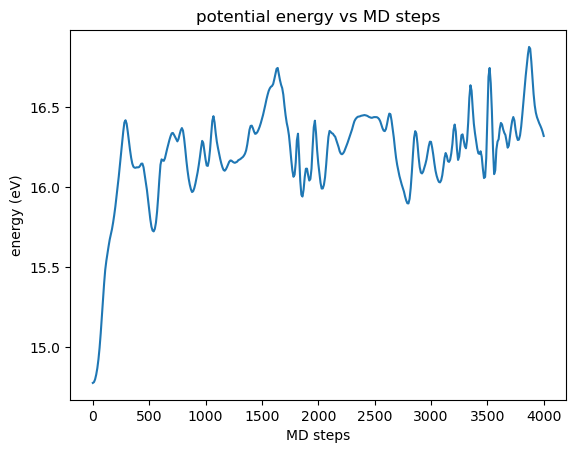

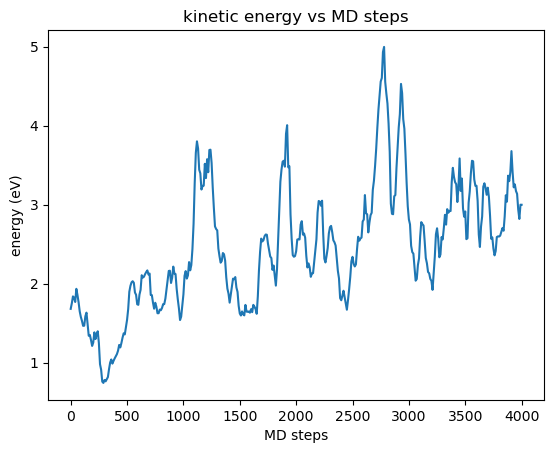

In [15]:
import matplotlib.pyplot as plt

steps = []
potential = []
kinetic = []

series = Trajectory('Pt-H2O.traj')
for i, atoms in enumerate(series):
    steps.append(i * 10)
    potential.append(atoms.get_potential_energy())
    kinetic.append(atoms.get_kinetic_energy())

plt.plot(steps, potential, label='potential energy (eV)')
plt.xlabel('MD steps')
plt.ylabel('energy (eV)')
plt.title('potential energy vs MD steps')
plt.show()

plt.plot(steps, kinetic, label='kinetic energy (eV)')
plt.xlabel('MD steps')
plt.ylabel('energy (eV)')
plt.title('kinetic energy vs MD steps')
plt.show()

体系的势能一开始最小，在之后的演化中上升，然后在较大值附近波动；而动能则一直在大范围内快速波动。这对应了两个水分子一开始处于束缚态（势能最小），之后脱离束缚的情况；而动能则因分子热运动而波动。似乎总能量在不断上升，可能是因为EMT势能只是近似势能，在描述本题的体系时不够适用。

通过上面的观察，你或许会对这两个水分子的运动产生兴趣。现在，让我们来借助`MDAnalysis`中的RDF工具来分析一下。

**(d)** 通过`MDAnalysis.analysis.rdf.InterRDF`计算出在两个水分子的相对构型较为稳定（换言之，两个水分子还没有明显分离）的若干帧下，氧原子之间的径向分布函数，并作图展示。

以下是对于参数设置的建议：
1. 待输入的晶格矩阵可以在之前得到的xyz文件内的“Lattice”关键词下找到
2. 把`select_atoms`中的参量从'all'改为'name O'，即可使选取范围限于体系的所有氧原子
3. 此处`bins`取为100，半径r的上界设在4~5埃左右是较为合适的选择

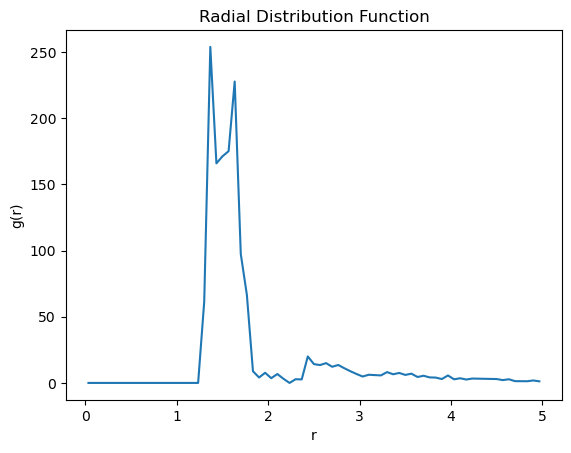

In [16]:
# 请基于下面已给出的部分代码进行完善
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import rdf
from ase.io import read, write

u = mda.Universe('Pt-H2O.xyz')  # 直接通过xyz文件创建Universe对象
start, stop, step = 0, 0, 0  # 根据你观察到的较为稳定的范围设置用于计算的帧区间

box_vectors = [
    [11.087434329005065, 0.0, 0.0],
    [5.5437171645025325, 9.601999791710057, 0.0],
    [0.0, 0.0, 46.789639165669996]
]

for ts in u.trajectory:
    ts.triclinic_dimensions = box_vectors

rdf_analyzer = rdf.InterRDF(
    u.select_atoms('name O'),
    u.select_atoms('name O'),
    range=(0, 5),
    bins=100,
    exclusion_block=(1,1)
)
rdf_analyzer.run()

r = rdf_analyzer.bins
gr = rdf_analyzer.rdf

plt.plot(r, gr)
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function')
plt.show()

* 根据上图，你得到的氧原子之间的平均距离大概是多少？
* 典型的以氢键相连的二聚水$(\text{H}_2\text{O})_2$的氧原子间距大约在1.7 $\mathring{\text{A}}$ ~2.0 $\mathring{\text{A}}$ 之间（实际上经常有更大范围的波动，不过在此我们先不考虑那么多），你得到的结果是否与此基本符合？
* 根据你之前的可视化观察结果，两个水分子分离前是否是靠氢键相连的？如果不是，请随意推测是什么原因导致了这种结果。

氧原子的平均距离大概是1.6埃左右。这和氢键相连的二聚水结果基本符合。但是在可视化结果中，两个水分子分离之前不是靠氢键相连的，应该是Pt表面的金属势导致了其与正常的二聚水不太一样。

本次作业用时不长，参考了课上的代码，一些原理上的问题问了ChatGPT。计算结果有些不稳定，跑了好多次才出这个看起来比较正常的结果。